# Setup

In [30]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter

# Timing Processes
import time

# Other
import warnings
warnings.simplefilter('once')

# make sure the figures plot inline rather than at the end
%matplotlib inline

# get data from tigress
path = '/home/jennap/projects/LRGROUP/shared_data/ssh_AVISO/'
infn = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2018.nc'

ds = xr.open_dataset(path + infn)
#print(ds.keys())

# Subset ------------------------------------------------#

# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(40, 100) # bounds inclusive

# Get data, selecting lat/lon slice
daily_sla = ds['sla'].sel(latitude=lat_slice,longitude=lon_slice)
lat = daily_sla.latitude.values
lon = daily_sla.longitude.values

# Create Grid -------------------------------------------#

# convert to a grid
[lon_grid, lat_grid] = np.meshgrid(lon,lat)

# Detrend SLA

Resources: [link](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Example_calculations_with_scalar_quantities.html), [link](https://groups.google.com/g/xarray/c/fz7HHgpgwk0), [link](https://stackoverflow.com/questions/28647172/numpy-polyfit-doesnt-handle-nan-values), [link](https://stackoverflow.com/questions/28647172/numpy-polyfit-doesnt-handle-nan-values), [link](https://stackoverflow.com/questions/17638137/curve-fitting-to-a-time-series-in-the-format-datetime)


In [2]:
# stack lat and lon into a single dimension called allpoints
stacked = daily_sla.stack(allpoints=['latitude','longitude'])

# set places where there are nans to zero since polyfit can't deal with them
stacked_nonan = stacked.fillna(0)

# convert date to a number to polyfit can handle it
datenum = dates.date2num(stacked_nonan.time)
daily_sla_slope, daily_sla_intercept = np.polyfit(datenum, stacked_nonan, 1)

#reshape the data
daily_sla_slope = np.reshape(daily_sla_slope, daily_sla.shape[1:3])
daily_sla_intercept = np.reshape(daily_sla_intercept, daily_sla.shape[1:3])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    x = dates.date2num(y.time)
    m, b = np.polyfit(x, y, 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# apply the function over allpoints to calculate the trend at each point
daily_sla_dtrnd = stacked_nonan.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
daily_sla_dtrnd = daily_sla_dtrnd.unstack('allpoints')

# fill all points we set originally to zero back to nan
daily_sla_dtrnd = daily_sla_dtrnd.where(~np.isnan(daily_sla))

# delete trended data to save on memory
del daily_sla,ds

# make plot for this to show difference..

# Downsample to Monthly and Seasonal Temporal Resolution

In [3]:
# seasonal
seas_sla_dtrnd = daily_sla_dtrnd.resample(time='QS-DEC').mean(dim="time")

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Find Climatologies 
Resources: [link](http://xarray.pydata.org/en/stable/examples/monthly-means.html)

In [4]:
# -------------------------------------------
# weighted seasonal
# -------------------------------------------

# all data
month_length = daily_sla_dtrnd.time.dt.days_in_month

# calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# calculate the weighted average
sla_seas_clim_dtrnd = (daily_sla_dtrnd * weights).groupby('time.season').sum(dim='time')   

# set the places that are now zero from the weights to nans
sla_seas_clim_dtrnd = sla_seas_clim_dtrnd.where(sla_seas_clim_dtrnd != 0,np.nan) # for some reason .where sets the locations not in the condition to nan by default


# Find Anomalies

In [6]:
# seasonal avg data - seasonal climatology
seas_sla_seas_anom_dtrnd = seas_sla_dtrnd.groupby('time.season') - sla_seas_clim_dtrnd

# Group Anomalies Into IOD Phases

Resources: [1](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2007JD009151),
[2](http://www.bom.gov.au/climate/iod/)

In [64]:
# eventually build some code to identify this yourself to include the years you couldn't find papers for

# lists of positive iod years for now taken from sources above 1994-2018 unsure after 2016
posIODyears = [1994,1997,2006,2012,2015]
# posIODwENSOyears = ['1997']
negIODyears = [1996,1998,2001,2010,2014,2016]
# negIODwENSOyears = ['1998']
neuIODyears = [1995,1999,2000,2002,2003,2004,2005,2007,2008,
               2009,2011,2012,2013]

# average over the positive IOD years -------------------------------------------# 
seas_data = []
for ii,year in enumerate(posIODyears):
    start_time = str(year) + '-03-01'
    end_time = str(year+1) + '-02-28'
    time_slice = slice(start_time, end_time)
    seas_data.append(seas_sla_seas_anom_dtrnd.sel(time=time_slice))

# add all the data together
posIOD_seas_sla_seas_anom_dtrnd = xr.concat(seas_data, dim='time')
# take the mean for each month of all the years
posIOD_seas_sla_seas_anom_dtrnd = posIOD_seas_sla_seas_anom_dtrnd.groupby('time.season').mean(dim='time')
#start in march instead of 01
posIOD_seas_sla_seas_anom_dtrnd = posIOD_seas_sla_seas_anom_dtrnd.roll(season = -1,roll_coords = False)

# average over the negative IOD years -------------------------------------------# 
seas_data = []
for ii,year in enumerate(negIODyears):
    start_time = str(year) + '-03-01'
    end_time = str(year+1) + '-02-28'
    time_slice = slice(start_time, end_time)
    seas_data.append(seas_sla_seas_anom_dtrnd.sel(time=time_slice))

negIOD_seas_sla_seas_anom_dtrnd = xr.concat(seas_data, dim='time')
negIOD_seas_sla_seas_anom_dtrnd = negIOD_seas_sla_seas_anom_dtrnd.groupby('time.season').mean(dim='time')
#start in march instead of 01
negIOD_seas_sla_seas_anom_dtrnd = negIOD_seas_sla_seas_anom_dtrnd.roll(season = -1,roll_coords = False)

# average over the neutral IOD years -------------------------------------------# 
seas_data = []
for ii,year in enumerate(neuIODyears):
    start_time = str(year) + '-03-01'
    end_time = str(year+1) + '-02-28'
    time_slice = slice(start_time, end_time)
    seas_data.append(seas_sla_seas_anom_dtrnd.sel(time=time_slice))
    
neuIOD_seas_sla_seas_anom_dtrnd = xr.concat(seas_data, dim='time')
neuIOD_seas_sla_seas_anom_dtrnd = neuIOD_seas_sla_seas_anom_dtrnd.groupby('time.season').mean(dim='time')
#start in march instead of 01
neuIOD_seas_sla_seas_anom_dtrnd = neuIOD_seas_sla_seas_anom_dtrnd.roll(season = -1,roll_coords = False)

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Put into 1 degress bins

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mea

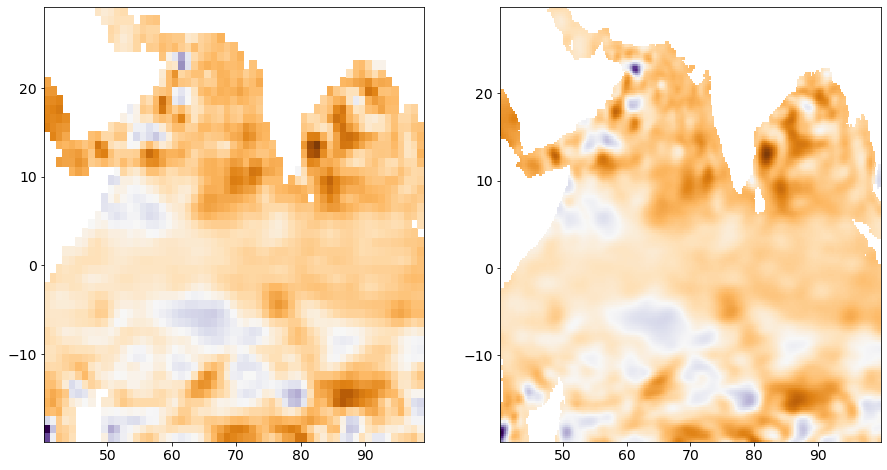

In [65]:
# coarsen to 1 degree boxes
def latlon_coarsen(invar,lat,lon,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon)
        ))
    

    # create 1 degree bins
    latedges = np.arange(lat.min()-(binwidth/2),lat.max()+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(lon.min()-(binwidth/2),lon.max()+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)
        
    # create pcolormesh lat/lon vals
    
    # extend longitude by 2
    lon_extend = np.zeros(lonbins.size+2)
    # fill in internal values
    lon_extend[1:-1] = lonbins # fill up with original values
    # fill in extra endpoints
    lon_extend[0] = lonbins[0]-np.diff(lonbins)[0]
    lon_extend[-1] = lonbins[-1]+np.diff(lonbins)[-1]
    # calculate the midpoints
    lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

    # extend latitude by 2
    lat_extend = np.zeros(latbins.size+2)
    # fill in internal values
    lat_extend[1:-1] = latbins
    # fill in extra endpoints
    lat_extend[0] = latbins[0]-np.diff(latbins)[0]
    lat_extend[-1] = latbins[-1]+np.diff(latbins)[-1]
    # calculate the midpoints
    lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))
    

    return(np.array(invar_binned_ave,dtype = float), 
           lonbins,latbins,lon_pcolormesh_midpoints,lat_pcolormesh_midpoints)

# bin
xx,yy = np.meshgrid(lon,lat)

# get lonbins and latbins to define sizes
_,lonbins,latbins,_,_ =latlon_coarsen(np.array(seas_sla_seas_anom_dtrnd[0,:,:]).ravel(),yy.ravel(),xx.ravel(),1)

# seasonal climatology
sla_seas_clim_dtrnd_1deg=np.zeros([sla_seas_clim_dtrnd.shape[0],len(latbins),len(lonbins)])
for tt in range(sla_seas_clim_dtrnd.shape[0]):
    sla_seas_clim_dtrnd_1deg[tt,:,:],lonbins,latbins,_,_ = latlon_coarsen(np.array(sla_seas_clim_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),1)

# seasonal anomaly
seas_sla_seas_anom_dtrnd_1deg=np.zeros([seas_sla_seas_anom_dtrnd.shape[0],len(latbins),len(lonbins)])
for tt in range(seas_sla_seas_anom_dtrnd.shape[0]):
    seas_sla_seas_anom_dtrnd_1deg[tt,:,:],lonbins,latbins,_,_ = latlon_coarsen(np.array(seas_sla_seas_anom_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),1)

# pos IOD
posIOD_seas_sla_seas_anom_dtrnd_1deg=np.zeros([posIOD_seas_sla_seas_anom_dtrnd.shape[0],len(latbins),len(lonbins)])    
for tt in range(posIOD_seas_sla_seas_anom_dtrnd.shape[0]):
    posIOD_seas_sla_seas_anom_dtrnd_1deg[tt,:,:],lonbins,latbins,_,_ = latlon_coarsen(np.array(posIOD_seas_sla_seas_anom_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),1)

# neg IOD
negIOD_seas_sla_seas_anom_dtrnd_1deg=np.zeros([negIOD_seas_sla_seas_anom_dtrnd.shape[0],len(latbins),len(lonbins)])    
for tt in range(negIOD_seas_sla_seas_anom_dtrnd.shape[0]):
    negIOD_seas_sla_seas_anom_dtrnd_1deg[tt,:,:],lonbins,latbins,_,_ = latlon_coarsen(np.array(negIOD_seas_sla_seas_anom_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),1)

# neu IOD
neuIOD_seas_sla_seas_anom_dtrnd_1deg=np.zeros([neuIOD_seas_sla_seas_anom_dtrnd.shape[0],len(latbins),len(lonbins)])    
for tt in range(neuIOD_seas_sla_seas_anom_dtrnd.shape[0]):
    neuIOD_seas_sla_seas_anom_dtrnd_1deg[tt,:,:],lonbins,latbins,_,_ = latlon_coarsen(np.array(neuIOD_seas_sla_seas_anom_dtrnd[tt,:,:]).ravel(),yy.ravel(),xx.ravel(),1)
    
    # # convert to xarray dataset

# data_set=xr.Dataset( coords={'lon': lonbins,
#                     'lat': latbins,
#                     'time': daily_sla_dtrnd.time})
# data_set["daily_sla_dtrnd_1deg"]=(['lat', 'lon', 'time'],  daily_sla_dtrnd_1deg)
# ds=xr.Dataset( coords={'lon': lonbins,
#                     'lat': latbins,
#                     'time': daily_sla_dtrnd.time})
# ds["daily_sla_dtrnd_1deg"]=(['time','lat', 'lon'],  daily_sla_dtrnd_1deg)
# save_path = '/projects/GEOCLIM/LRGROUP/jennap/Modulation_of_Coastal_Hypoxia_by_the_IOD/data/'
# ds.to_netcdf(save_path + infn[:-3] + '_1deg.nc',mode='w',format = "NETCDF4")

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1,2,1)
plt.pcolormesh(lonbins,latbins,seas_sla_seas_anom_dtrnd_1deg[0,:,:],cmap=plt.cm.PuOr_r)
ax = fig.add_subplot(1,2,2)
plt.pcolormesh(xx,yy,seas_sla_seas_anom_dtrnd[0,:,:],cmap=plt.cm.PuOr_r)

# Find Coastlines

Text(0.5, 1.0, 'Unordered Stations')

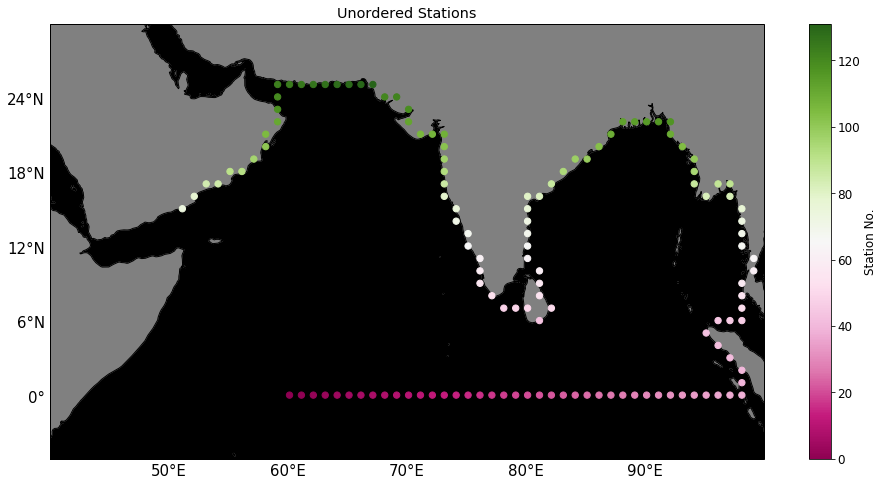

In [58]:
# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = seas_sla_seas_anom_dtrnd_1deg[0,:,:]
xx,yy = np.meshgrid(lonbins,latbins)
# set Gulfs to Nans
mask = np.where(~((yy>22) & (xx<59)),mask,np.nan)
mask = np.where(~((yy>10) & (xx<51)),mask,np.nan)

# AS inlets
mask = np.where(~((yy>21.5) & (yy<23) & (xx>72) & (xx<73)),mask,np.nan)
mask = np.where(~((yy>22.25) & (yy<23) & (xx>69) & (xx<70.5)),mask,np.nan)
mask = np.where(~((yy>23.25) & (yy<24) & (xx>68.5) & (xx<70)),mask,np.nan)

# sri lanka are
mask = np.where(~((yy>8) & (yy<10.5) & (xx>78) & (xx<80.5)),mask,np.nan)

# Sumatra area
mask = np.where(~((yy>4.5) & (yy<5.5) & (xx>95.5) & (xx<100)),mask,np.nan)
mask = np.where(~((yy>3) & (yy<5.5) & (xx>97.5) & (xx<100)),mask,np.nan)
mask = np.where(~((yy>0) & (yy<10) & (xx>99) & (xx<101)),mask,np.nan)
mask = np.where(~((yy>11.5) & (yy<13) & (xx>99)),mask,np.nan)

# equator
mask = np.where(~(yy<0),mask,np.nan)
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
#         cond = (~np.isnan(arr[row,col])) & (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),max(0,col-1):min(arr.shape[1],col+2)])))
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

#         if  (~np.isnan(arr[row,col])) & cond):
        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))

# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

sta_latinds_unord = sta_latinds_unord[17:]
sta_loninds_unord = sta_loninds_unord[17:]

# AS
lons_from_sta = lonbins[sta_loninds_unord]
lats_from_sta = latbins[sta_latinds_unord]

ind = ~((lons_from_sta <52) & (lats_from_sta < 15))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

#BoB
lons_from_sta = lonbins[sta_loninds_unord]
lats_from_sta = latbins[sta_latinds_unord]

ind = ~(lons_from_sta >101)
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

bounds = [40,100,-5,30]

def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
# cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
plt.scatter(lonbins[sta_loninds_unord],latbins[sta_latinds_unord],
            s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
plt.colorbar(label = 'Station No.')
plt.title('Unordered Stations')

No Next Station Found. Returning Previous Stations Only.
(11, 35) [(58, 26), (58, 20)]


Text(0.5, 1.0, 'Ordered Stations')

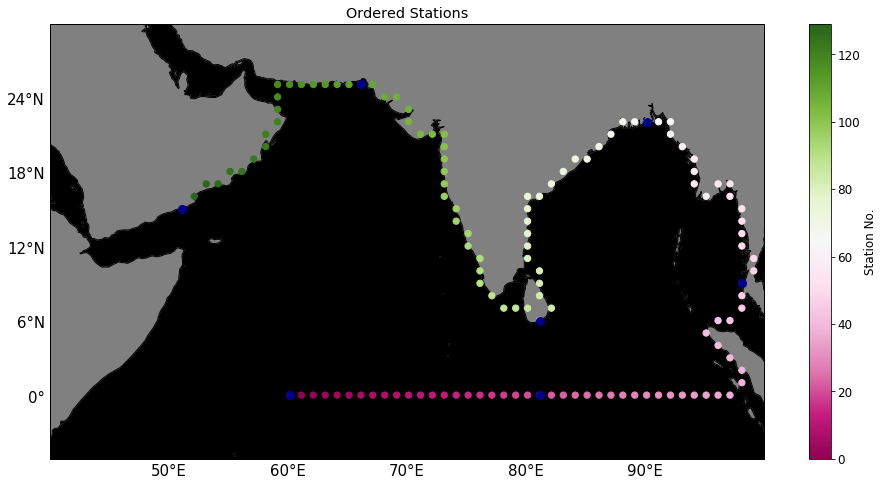

In [59]:
# ------------------------------------------------------------#
# put in the right order
# ------------------------------------------------------------#


def order_coast(loninds,latinds,sta_zero):
    # find based on radius
    zipped_lists = zip(loninds, latinds)
    sorted_pairs = sorted(zipped_lists, reverse=True)

    # sort by lon
    tuples = zip(*sorted_pairs)
    lon_list,lat_list  = [ list(tuple) for tuple in  tuples]

    pos = []
    curr_sta = []
    rem_sta = sorted_pairs
    for i in range(len(lon_list)):
#         print(i)
        if i == 0:
            curr_sta.append(sta_zero)
            rem_sta.remove(sta_zero) 
            prev_sta = sta_zero
        else:
            prev_sta = curr_sta[i-1]

        start_len = len(curr_sta)
        for j,(lo, la) in enumerate(rem_sta):
            next_sta = (rem_sta[j])
            
            diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))
            
            # check uplr first
            if(next_sta != prev_sta) & (all(np.abs(diff) == [0,1])) | (all(np.abs(diff) == [1,0])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break

            # then check diagonals
            elif (next_sta != prev_sta) & (all(np.abs(diff) == [1,1])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break
                
        if len(curr_sta) == start_len:
            print('No Next Station Found. Returning Previous Stations Only.')
            print(curr_sta[i],rem_sta)
            break
        
    sta_lonind, sta_latind  = map(np.array, zip(*curr_sta))
    
    return sta_lonind, sta_latind

#initial station
sta_zero = (sta_loninds_unord[0],sta_latinds_unord[0]) # 98.625, 10.375

#calculate
sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)

# ------------------------------------------------------------#
# identify first stations for EQ, BOB, and AS
# ------------------------------------------------------------#

EQ = 0
JA = 21
sBoB = 47
mBoB = 65
SL = 85
mAS = 110
eAS = 129
loc_list = [EQ,JA,sBoB,mBoB,SL,mAS,eAS]

# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
bounds = [40,100,-5,30]

def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
# cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
# xx,yy = np.meshgrid(lon,lat)
# plt.scatter(xx.flatten(),yy.flatten(),s = 160,c='w',marker = '.')
p =plt.scatter(lonbins[sta_loninds],latbins[sta_latinds],
            s = 160,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.PiYG) 
plt.scatter(lonbins[sta_loninds[loc_list]],latbins[sta_latinds[loc_list]],
            s = 260,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')
plt.title('Ordered Stations')

# Hovmueller Diagrams

## Interannual Data

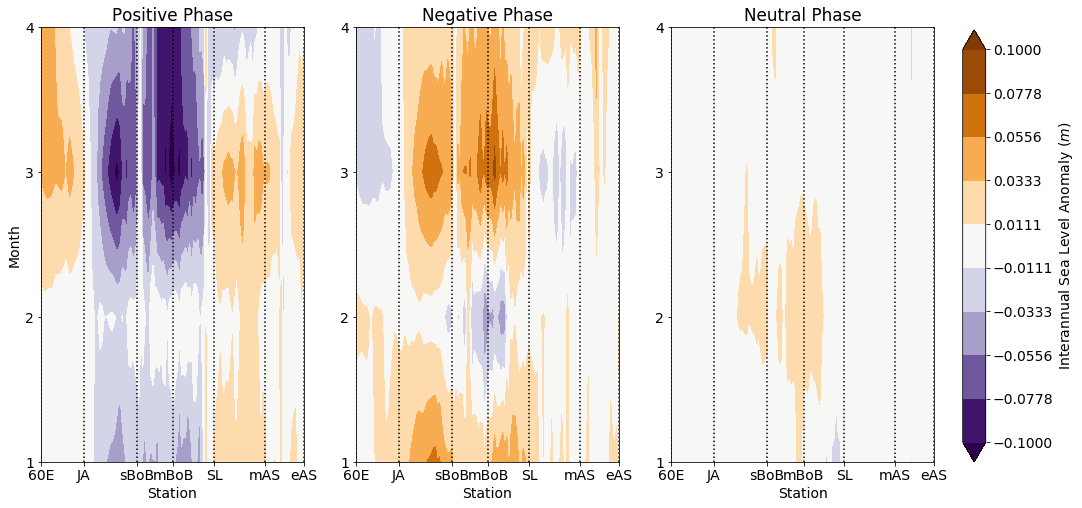

In [66]:
# create list of integer years
IODphases = list([posIOD_seas_sla_seas_anom_dtrnd_1deg,negIOD_seas_sla_seas_anom_dtrnd_1deg,
                  neuIOD_seas_sla_seas_anom_dtrnd_1deg])
titles = ['Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 14})

cmin = -0.1
cmax = 0.1

fig = plt.figure(figsize=(16, 8))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = np.arange(1,5)
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
#     ax.set_yticklabels(['03', '04', '05','06','07','08','09','10','11','12','01','02'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','JA', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,5)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Interannual Sea Level Anomaly ($m$)')


## Seasonal

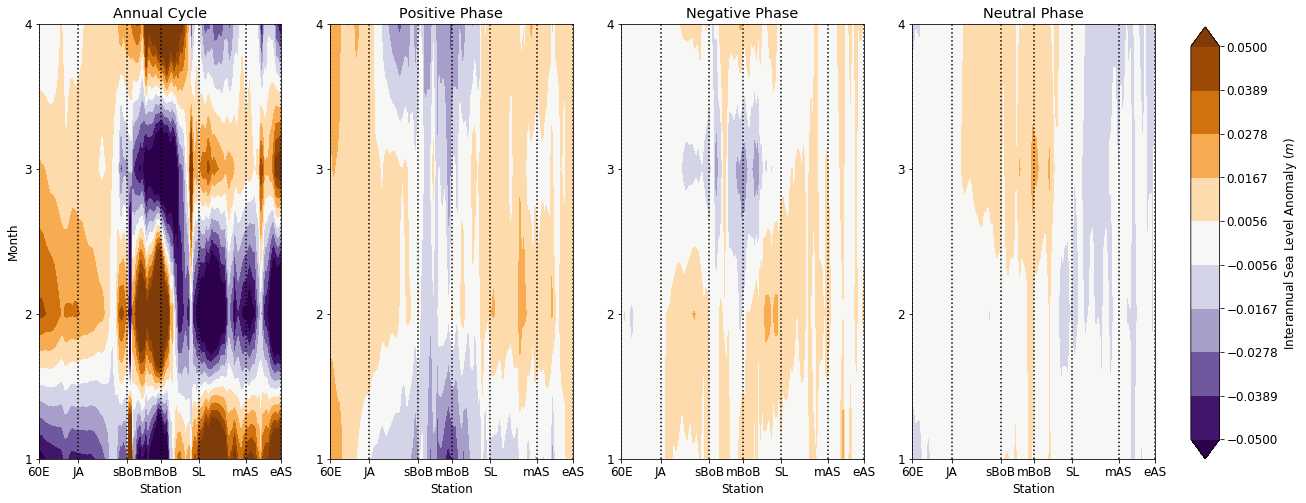

In [55]:
# create list of integer years
IODphases = list([sla_seas_clim_dtrnd_1deg,posIOD_seas_sla_seas_anom_dtrnd_1deg,negIOD_seas_sla_seas_anom_dtrnd_1deg,
                  neuIOD_seas_sla_seas_anom_dtrnd_1deg])
titles = ['Annual Cycle','Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 12})

cmin = -0.05
cmax = 0.05

fig = plt.figure(figsize=(20, 8))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = np.arange(1,5)
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,4,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
#     ax.set_yticklabels(['03', '04', '05','06','07','08','09','10','11','12','01','02'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','JA', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,5)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Interannual Sea Level Anomaly ($m$)')



In [45]:
sla_seas_clim_dtrnd.season

<xarray.DataArray 'season' (season: 4)>
array(['DJF', 'JJA', 'MAM', 'SON'], dtype=object)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'